In [ ]:
# Install tensorflow (if not installed)
!pip install tensorflow

In [65]:
import numpy as np 
from ml.nn import Model, Dense, ReLU, Sigmoid, AccuracyRegression
from ml.losses import MeanSquareError, BinaryCrossentropy
from ml.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

### Load the MNIST dataset  
We only need the images for an autoencoder,  
so the label arrays are kept but never used during training.

In [66]:
(y_train, labels_train), (y_test, labels_test) = mnist.load_data()

### Pre-process the images and create a noisy copy  
1. Reshape each image to a flat 784-dimensional vector.  
2. Scale pixel values to **0 – 1** for stable training.  
3. Add pixel-wise Gaussian noise so the autoencoder must learn to denoise.  
   The clean images are our training targets, the noisy versions our inputs.

In [67]:
# 1 
y_train = (y_train.reshape(y_train.shape[0], -1).astype(np.float32))
y_test = (y_test.reshape(y_test.shape[0], -1).astype(np.float32))
# 2 
y_train = np.where(y_train > 0, 1, 0)
y_test = np.where(y_test > 0, 1, 0)
# 3
noise = np.random.normal(scale=0.5, size=y_test[0].shape)
X_train, X_test = y_train + noise, y_test + noise

### Visual sanity-check  
Display one of the noisy training images to confirm
the corruption process worked as expected.

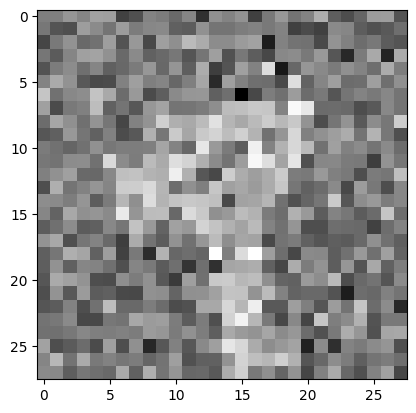

In [68]:
plt.imshow(X_train[4].reshape(28,28), cmap='gray')

In [69]:
X_train.shape

(60000, 784)

### Define a symmetric denoising autoencoder  
Encoder: 784 → 32 → 16 • Decoder: 16 → 32 → 784  

* **ReLU** in the hidden layers.  
* **Sigmoid** output so every reconstructed pixel is in 0 – 1.  

> **Note:** `AccuracyRegression()` is attached because the `Model.set()`  
> API requires an accuracy object, but we will *not* read that metric later;  
> reconstruction quality is judged solely by the loss curve.

In [70]:
model = Model()
model.add(Dense(784, 32))
model.add(ReLU())
model.add(Dense(32, 16))
model.add(ReLU())
model.add(Dense(16, 16))
model.add(Dense(16, 32))
model.add(ReLU())
model.add(Dense(32, 784))
model.add(Sigmoid())

model.set(loss=BinaryCrossentropy(),
          optimizer=Adam(learning_rate=0.005),
          accuracy=AccuracyRegression())

model.finalize()

### Model summary  
Print the layer stack and total number of trainable parameters.

In [71]:
model.summary(X_train.shape[1])

╔══════════════════════════════════════╗
║          Model Architecture          ║
╠════╬═════════╬══════════════╬════════╣
║ #  ║ Layer   ║ Output Shape ║ Params ║
╠════╬═════════╬══════════════╬════════╣
║ 1  ║ Dense   ║ (None, 32)   ║  25120 ║
║ 2  ║ ReLU    ║ (None, 32)   ║      0 ║
║ 3  ║ Dense   ║ (None, 16)   ║    528 ║
║ 4  ║ ReLU    ║ (None, 16)   ║      0 ║
║ 5  ║ Dense   ║ (None, 16)   ║    272 ║
║ 6  ║ Dense   ║ (None, 32)   ║    544 ║
║ 7  ║ ReLU    ║ (None, 32)   ║      0 ║
║ 8  ║ Dense   ║ (None, 784)  ║  25872 ║
║ 9  ║ Sigmoid ║ (None, 784)  ║      0 ║
╚════╩═════════╩══════════════╩════════╝
Total trainable parameters: 52,336


### Train the denoising autoencoder  
75 epochs, batch size 128.  
`AccuracyRegression()` is logged but not interpreted;  
focus on the Binary-Cross-Entropy loss for progress tracking.

In [72]:
model.train(X_train, y_train, epochs=75, batch_size=128, print_every=100, validation_data=(X_test, y_test))

epoch: 1
step: 0, acc: 0.501 loss: 0.693 data_loss: 0.693 reg_loss: 0.000 lr: 0.005
step: 100, acc: 0.838 loss: 0.298 data_loss: 0.298 reg_loss: 0.000 lr: 0.005
step: 200, acc: 0.839 loss: 0.294 data_loss: 0.294 reg_loss: 0.000 lr: 0.005
step: 300, acc: 0.857 loss: 0.267 data_loss: 0.267 reg_loss: 0.000 lr: 0.005
step: 400, acc: 0.849 loss: 0.289 data_loss: 0.289 reg_loss: 0.000 lr: 0.005
step: 468, acc: 0.844 loss: 0.299 data_loss: 0.299 reg_loss: 0.000 lr: 0.005
training, acc: 663.356 loss: 0.298 data_loss: 0.298 reg_loss: 0.000 lr: 0.005
validation, acc: 669.462 loss: 0.285
epoch: 2
step: 0, acc: 0.860 loss: 0.277 data_loss: 0.277 reg_loss: 0.000 lr: 0.005
step: 100, acc: 0.856 loss: 0.277 data_loss: 0.277 reg_loss: 0.000 lr: 0.005
step: 200, acc: 0.856 loss: 0.279 data_loss: 0.279 reg_loss: 0.000 lr: 0.005
step: 300, acc: 0.868 loss: 0.257 data_loss: 0.257 reg_loss: 0.000 lr: 0.005
step: 400, acc: 0.854 loss: 0.282 data_loss: 0.282 reg_loss: 0.000 lr: 0.005
step: 468, acc: 0.845 lo

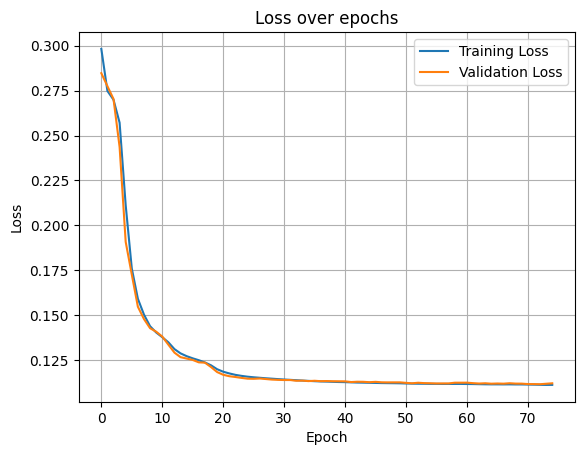

validation, acc: 746.898 loss: 0.112


In [73]:
model.plot_loss()
model.evaluate(X_test, y_test)


### Noisy input vs. reconstructed output  
Top row – corrupted inputs.  
Bottom row – model reconstructions.  
The ground-truth digit label is shown in the title for reference.

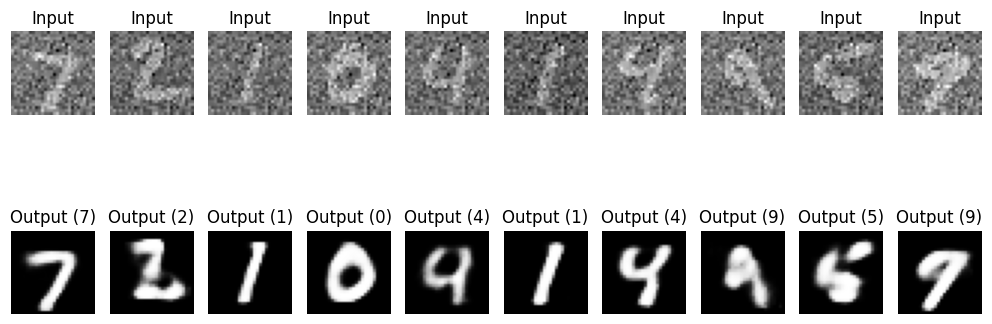

In [74]:
plt.figure(figsize=(10, 5))

for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title("Input")
    ax.axis('off')

    ax = plt.subplot(2, 10, 10 + i + 1)
    ax.imshow(model.predict(X_test[i]).reshape(28, 28), cmap='gray')
    ax.set_title(f"Output ({labels_test[i]})")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Inspect a single reconstruction in detail  
Visualise the model’s output for test sample #100.

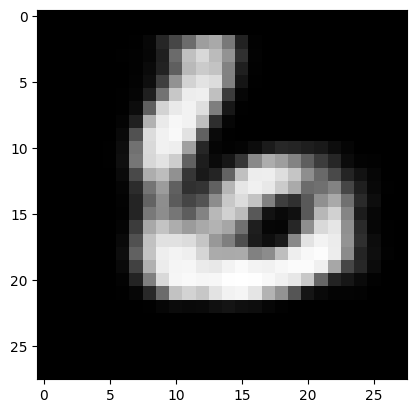

In [75]:
plt.imshow(model.predict(X_test[100]).reshape(28,28), cmap='gray')